In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Wasserstein loss function
def wasserstein_loss(y_true, y_pred):
    return torch.mean(y_true * y_pred)

# Critic Model
class Critic(nn.Module):
    def __init__(self, depth=64):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, depth, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(depth),
            nn.LeakyReLU(0.2),
            nn.Conv2d(depth, depth * 2, kernel_size=3, stride=4, padding=1),
            nn.BatchNorm2d(depth * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(depth * 2, depth * 4, kernel_size=3, stride=4, padding=1),
            nn.BatchNorm2d(depth * 4),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(depth * 4 * 4 * 4, 1)
        )

    def forward(self, x):
        return self.model(x)

# Generator Model
class Generator(nn.Module):
    def __init__(self, depth=256, dim=4):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 64 * dim * dim),
            nn.LeakyReLU(0.2),
            nn.Unflatten(-1, (64, dim, dim)),
            nn.ConvTranspose2d(64, 128, kernel_size=dim, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 256, kernel_size=dim, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 256, kernel_size=dim, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 256, kernel_size=dim, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Define the WGAN
class WGAN(nn.Module):
    def __init__(self, generator, critic):
        super(WGAN, self).__init__()
        self.generator = generator
        self.critic = critic

    def forward(self, z):
        fake_images = self.generator(z)
        critic_output = self.critic(fake_images)
        return critic_output

# Training the WGAN
def train_wgan(generator, critic, wgan, data, latent_dim=100, n_epochs=300, batch_size=64, critic_iterations=5):
    # Prepare optimizers
    optimizer_critic = optim.RMSprop(critic.parameters(), lr=0.00005)
    optimizer_generator = optim.RMSprop(generator.parameters(), lr=0.00005)

    for epoch in range(n_epochs):
        for i in range(0, len(data), batch_size):
            real_images = data[i:i + batch_size].to(device)  # Assuming data is already a PyTorch tensor
            half_batch = real_images.size(0) // 2
            
            # Train critic
            for _ in range(critic_iterations):
                optimizer_critic.zero_grad()

                # Train on real images
                real_labels = -torch.ones(half_batch, 1).to(device)
                real_loss = wasserstein_loss(real_labels, critic(real_images[:half_batch]))
                real_loss.backward()

                # Train on fake images
                noise = torch.randn(half_batch, 100).to(device)
                fake_images = generator(noise)
                fake_labels = torch.ones(half_batch, 1).to(device)
                fake_loss = wasserstein_loss(fake_labels, critic(fake_images.detach()))
                fake_loss.backward()

                optimizer_critic.step()

            # Train generator
            optimizer_generator.zero_grad()
            noise = torch.randn(batch_size, 100).to(device)
            generated_images = generator(noise)
            labels = -torch.ones(batch_size, 1).to(device)
            g_loss = wasserstein_loss(labels, critic(generated_images))
            g_loss.backward()
            optimizer_generator.step()

            # Log progress (you can customize this as needed)
            if i % 100 == 0:
                print(f'Epoch: {epoch}, Step: {i}, D Loss: {real_loss.item() + fake_loss.item()}, G Loss: {g_loss.item()}')

# Usage
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
data = torch.randn(1000, 3, 128, 128).to(device)  # Example data tensor

critic = Critic().to(device)
generator = Generator().to(device)
wgan = WGAN(generator, critic).to(device)
generator(data)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (384000x128 and 100x1024)

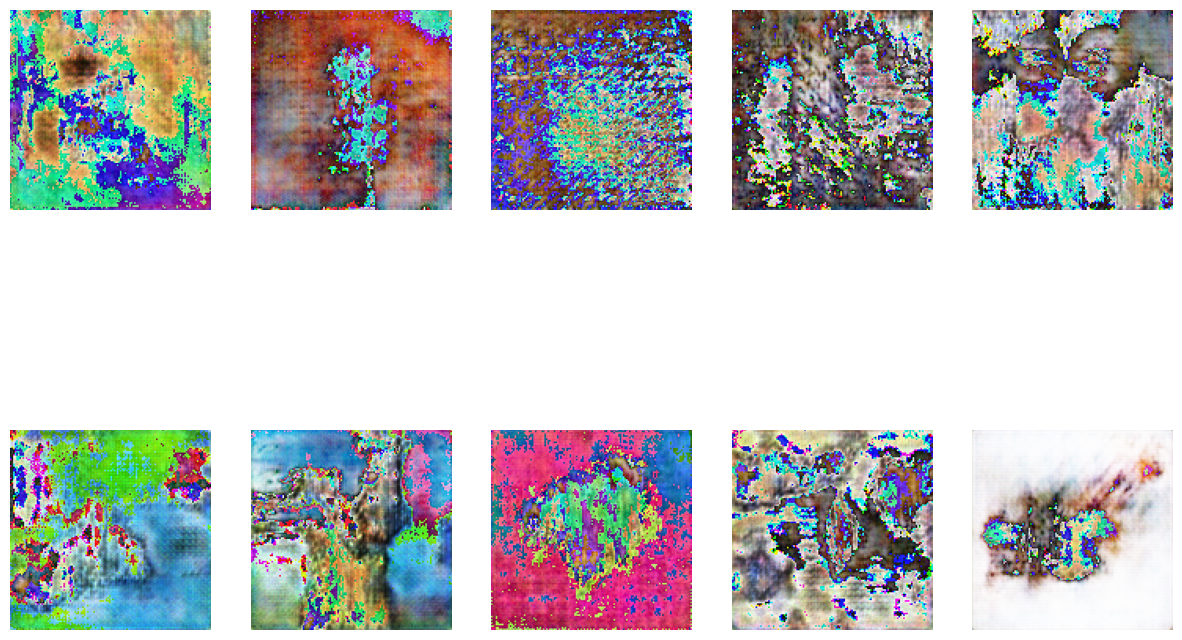

In [5]:
trainer.show()